In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 128
EPOCHS = 100
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,type2,image_fn
0,Bulbasaur,1,Grass,Poison,['1']
1,Ivysaur,2,Grass,Poison,['2']
2,Venusaur,3,Grass,Poison,['3']
3,Venusaur Gmax,3,Grass,Poison,['3_g']
4,Venusaur Mega,3,Grass,Poison,['3_2']
...,...,...,...,...,...
1113,Glastrier,896,Ice,NaN,['896']
1114,Spectrier,897,Ghost,NaN,['897']
1115,Calyrex,898,Psychic,Grass,['898_1']
1116,Calyrex Ice Rider,898,Psychic,Ice,['898_2']


- The shape of the dataset is: (128, 32, 32, 3) => batch_size: 128, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (128, 18) => batch_size: 128, number of labels: 18


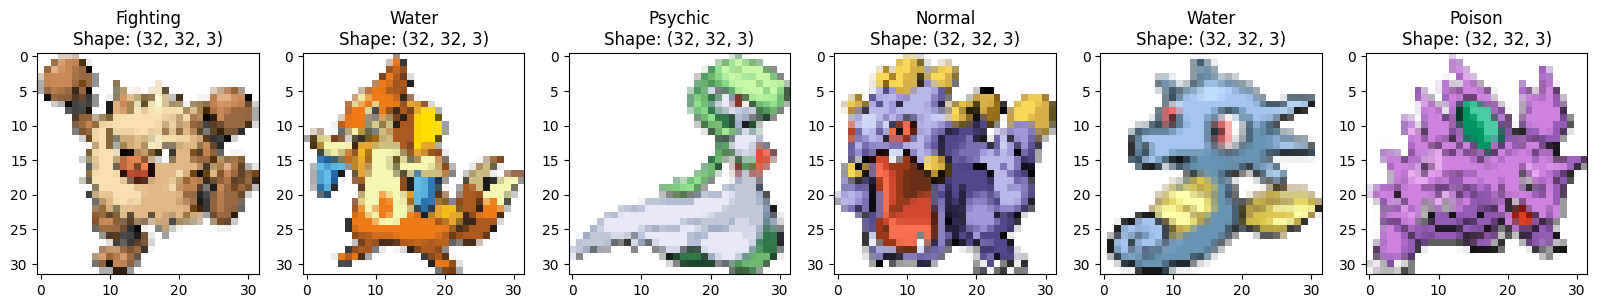

In [5]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=32,
    batch_size=128,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [13]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, 500, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1714428009.166872   74348 service.cc:145] XLA service 0x76bdc8002f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714428009.166900   74348 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1714428009.615612   74348 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1714428011.303177   74517 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2982', 24 bytes spill stores, 40 bytes spill loads

I0000 00:00:1714428011.555938   74519 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5498', 36 bytes spill stores, 44 bytes spill loads

I0000 00:00:1714428011.725197   74524 asm_compiler.cc:369] ptxas war

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 1.8512  

I0000 00:00:1714428024.518649   74348 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - loss: 1.1823
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.7901
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.4264
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.2478
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.2318
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.1912
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.1693
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.1586
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.1997
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.2729
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2464
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1977
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2001
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1180
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1668


Sampling sprite: 500it [00:21, 23.06it/s]                         


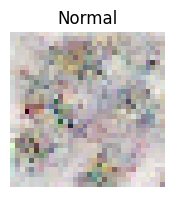

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 826ms/step - loss: 0.1142
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.1438
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1265
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1302
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1341
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0989
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1353
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1125
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1103
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0814
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1306
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1510
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1174
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1258
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss

Sampling sprite: 500it [00:20, 24.22it/s]                         


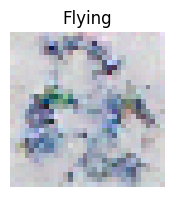

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 791ms/step - loss: 0.1167
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1133
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0853
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1049
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0923
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0913
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1472
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1708
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1521
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1053
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1248
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1428
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1526
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1214
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss

Sampling sprite: 500it [00:20, 24.10it/s]                         


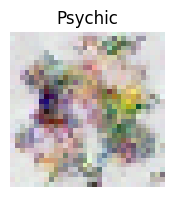

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 795ms/step - loss: 0.1480
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1213
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0625
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1086
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1300
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1884
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.2226
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1290
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1203
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1285
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0813
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0912
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1189
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0787
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss

Sampling sprite: 500it [00:20, 23.89it/s]                         


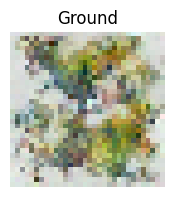

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 801ms/step - loss: 0.1368
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0944
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1286
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1308
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1582
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1685
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1644
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1980
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1081
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1301
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1163
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1142
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.1117
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1297
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss

Sampling sprite: 500it [00:20, 23.92it/s]                         


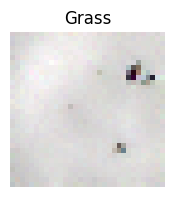

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 800ms/step - loss: 0.1316


In [14]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1506
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1240
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0924
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1312
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1396
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1620
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1118
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1376
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1666
Epoch 10/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0899
Epoch 11/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0606
Epoch 12/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0784
Epoch 13/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1080
Epoch 14/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0646
Epoch 15/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - lo

Sampling sprite: 500it [00:20, 23.94it/s]                         


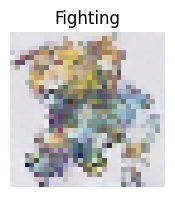

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 799ms/step - loss: 0.1268
Epoch 21/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1192
Epoch 22/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1101
Epoch 23/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1568
Epoch 24/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1026
Epoch 25/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0846
Epoch 26/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0999
Epoch 27/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1545
Epoch 28/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1147
Epoch 29/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0925
Epoch 30/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1139
Epoch 31/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0708
Epoch 32/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1560
Epoch 33/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1335
Epoch 34/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss

Sampling sprite: 500it [00:21, 23.60it/s]                         


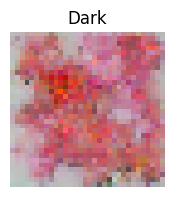

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 810ms/step - loss: 0.1182
Epoch 41/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1248
Epoch 42/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1063
Epoch 43/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0680
Epoch 44/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0619
Epoch 45/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1578
Epoch 46/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1000
Epoch 47/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0908
Epoch 48/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1098
Epoch 49/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0807
Epoch 50/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0933
Epoch 51/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1028
Epoch 52/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0684
Epoch 53/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1278
Epoch 54/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss

Sampling sprite: 500it [00:21, 23.63it/s]                         


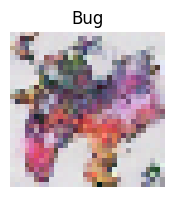

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 809ms/step - loss: 0.1097
Epoch 61/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1044
Epoch 62/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0975
Epoch 63/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0713
Epoch 64/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1074
Epoch 65/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1088
Epoch 66/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0743
Epoch 67/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0871
Epoch 68/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0615
Epoch 69/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1268
Epoch 70/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1659
Epoch 71/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1809
Epoch 72/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0871
Epoch 73/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0940
Epoch 74/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss

Sampling sprite: 500it [00:21, 23.79it/s]                         


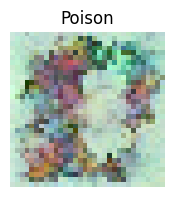

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 804ms/step - loss: 0.1248
Epoch 81/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1200
Epoch 82/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0891
Epoch 83/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0875
Epoch 84/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0931
Epoch 85/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0663
Epoch 86/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1004
Epoch 87/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0821
Epoch 88/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1325
Epoch 89/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1197
Epoch 90/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0768
Epoch 91/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1219
Epoch 92/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0787
Epoch 93/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0762
Epoch 94/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss

Sampling sprite: 500it [00:20, 23.82it/s]                         


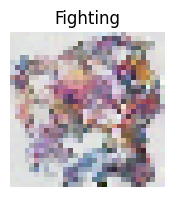

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 803ms/step - loss: 0.0978
Epoch 101/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1425
Epoch 102/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1404
Epoch 103/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0895
Epoch 104/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0863
Epoch 105/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0645
Epoch 106/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1067
Epoch 107/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1307
Epoch 108/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0749
Epoch 109/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0884
Epoch 110/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1078
Epoch 111/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0876
Epoch 112/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0958
Epoch 113/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0841
Epoch 114/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.63it/s]                         


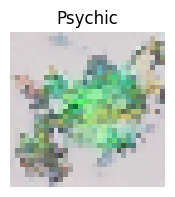

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 809ms/step - loss: 0.1254
Epoch 121/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0757
Epoch 122/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0788
Epoch 123/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0841
Epoch 124/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0676
Epoch 125/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0866
Epoch 126/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1815
Epoch 127/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.2027
Epoch 128/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1101
Epoch 129/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0908
Epoch 130/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1068
Epoch 131/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1168
Epoch 132/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1230
Epoch 133/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1437
Epoch 134/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:20, 23.93it/s]                         


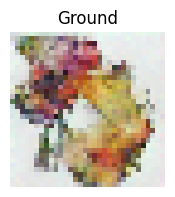

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 800ms/step - loss: 0.0923
Epoch 141/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1101
Epoch 142/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1560
Epoch 143/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1055
Epoch 144/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0785
Epoch 145/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1245
Epoch 146/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1134
Epoch 147/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0673
Epoch 148/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1047
Epoch 149/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0849
Epoch 150/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1284
Epoch 151/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1420
Epoch 152/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1000
Epoch 153/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0870
Epoch 154/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:20, 23.81it/s]                         


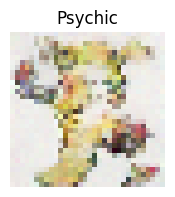

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 803ms/step - loss: 0.0945
Epoch 161/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0804
Epoch 162/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0605
Epoch 163/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0740
Epoch 164/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1325
Epoch 165/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1116
Epoch 166/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1266
Epoch 167/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0948
Epoch 168/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1355
Epoch 169/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1574
Epoch 170/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1233
Epoch 171/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1054
Epoch 172/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1195
Epoch 173/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1063
Epoch 174/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.72it/s]                         


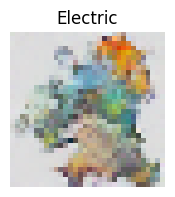

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 806ms/step - loss: 0.0687
Epoch 181/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1241
Epoch 182/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1430
Epoch 183/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0706
Epoch 184/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1683
Epoch 185/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1102
Epoch 186/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1037
Epoch 187/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0891
Epoch 188/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1366
Epoch 189/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0537
Epoch 190/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1089
Epoch 191/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1068
Epoch 192/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1036
Epoch 193/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0998
Epoch 194/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.66it/s]                         


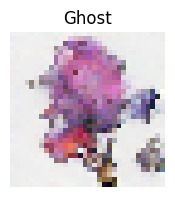

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 808ms/step - loss: 0.0861
Epoch 201/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1284
Epoch 202/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0919
Epoch 203/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0993
Epoch 204/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0725
Epoch 205/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0763
Epoch 206/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0952
Epoch 207/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0809
Epoch 208/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0992
Epoch 209/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0949
Epoch 210/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0736
Epoch 211/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0932
Epoch 212/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0780
Epoch 213/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0575
Epoch 214/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.57it/s]                         


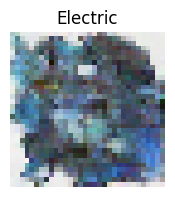

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 811ms/step - loss: 0.0803
Epoch 221/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1039
Epoch 222/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1051
Epoch 223/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0875
Epoch 224/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0688
Epoch 225/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0474
Epoch 226/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0719
Epoch 227/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0957
Epoch 228/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1034
Epoch 229/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1466
Epoch 230/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1038
Epoch 231/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0869
Epoch 232/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0763
Epoch 233/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0907
Epoch 234/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:22, 22.03it/s]                         


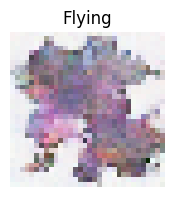

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 859ms/step - loss: 0.0971
Epoch 241/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0644
Epoch 242/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0914
Epoch 243/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0918
Epoch 244/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1057
Epoch 245/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0708
Epoch 246/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1017
Epoch 247/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1464
Epoch 248/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0902
Epoch 249/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1149
Epoch 250/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0418
Epoch 251/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1086
Epoch 252/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0707
Epoch 253/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0710
Epoch 254/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88

Sampling sprite: 500it [00:21, 23.32it/s]                         


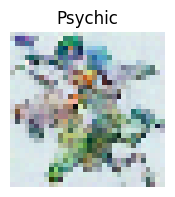

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 818ms/step - loss: 0.1061
Epoch 261/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.1401
Epoch 262/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1074
Epoch 263/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0763
Epoch 264/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0755
Epoch 265/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0932
Epoch 266/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0652
Epoch 267/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0790
Epoch 268/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.1123
Epoch 269/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0599
Epoch 270/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0659
Epoch 271/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.1368
Epoch 272/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0907
Epoch 273/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.1402
Epoch 274/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88

Sampling sprite: 500it [00:21, 23.39it/s]                         


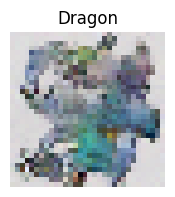

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 815ms/step - loss: 0.1059
Epoch 281/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1259
Epoch 282/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1005
Epoch 283/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1390
Epoch 284/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0633
Epoch 285/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1023
Epoch 286/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0884
Epoch 287/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0962
Epoch 288/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0884
Epoch 289/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0763
Epoch 290/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0775
Epoch 291/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1177
Epoch 292/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0985
Epoch 293/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1080
Epoch 294/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.71it/s]                         


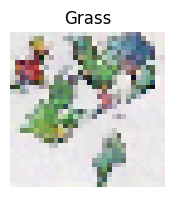

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 806ms/step - loss: 0.1092
Epoch 301/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1247
Epoch 302/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1199
Epoch 303/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1015
Epoch 304/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0906
Epoch 305/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1192
Epoch 306/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0565
Epoch 307/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1154
Epoch 308/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1119
Epoch 309/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0585
Epoch 310/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0986
Epoch 311/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0827
Epoch 312/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0635
Epoch 313/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0776
Epoch 314/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.71it/s]                         


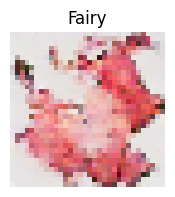

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 806ms/step - loss: 0.1307
Epoch 321/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1094
Epoch 322/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1021
Epoch 323/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1074
Epoch 324/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1071
Epoch 325/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1311
Epoch 326/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1215
Epoch 327/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0735
Epoch 328/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0897
Epoch 329/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1401
Epoch 330/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0587
Epoch 331/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0609
Epoch 332/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0632
Epoch 333/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0635
Epoch 334/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.70it/s]                         


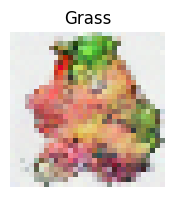

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 807ms/step - loss: 0.1003
Epoch 341/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0721
Epoch 342/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0855
Epoch 343/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1050
Epoch 344/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1086
Epoch 345/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0933
Epoch 346/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1263
Epoch 347/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0939
Epoch 348/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1360
Epoch 349/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1153
Epoch 350/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0710
Epoch 351/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1228
Epoch 352/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0673
Epoch 353/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0835
Epoch 354/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.71it/s]                         


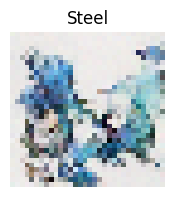

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 806ms/step - loss: 0.1042
Epoch 361/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0575
Epoch 362/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1273
Epoch 363/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1112
Epoch 364/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1172
Epoch 365/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1065
Epoch 366/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1860
Epoch 367/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1083
Epoch 368/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1295
Epoch 369/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1108
Epoch 370/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0962
Epoch 371/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1018
Epoch 372/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0592
Epoch 373/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0805
Epoch 374/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.42it/s]                         


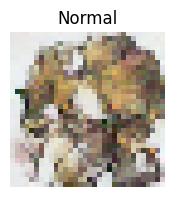

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 815ms/step - loss: 0.0894
Epoch 381/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0601
Epoch 382/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0730
Epoch 383/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0776
Epoch 384/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0895
Epoch 385/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0692
Epoch 386/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1102
Epoch 387/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1254
Epoch 388/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1128
Epoch 389/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1113
Epoch 390/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0672
Epoch 391/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0785
Epoch 392/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1084
Epoch 393/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0605
Epoch 394/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.31it/s]                         


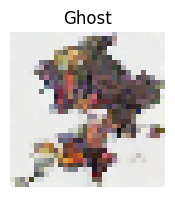

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 818ms/step - loss: 0.1027
Epoch 401/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0919
Epoch 402/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0862
Epoch 403/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1056
Epoch 404/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0630
Epoch 405/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1141
Epoch 406/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0637
Epoch 407/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1018
Epoch 408/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1087
Epoch 409/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0812
Epoch 410/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0750
Epoch 411/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1265
Epoch 412/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0735
Epoch 413/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0819
Epoch 414/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.43it/s]                         


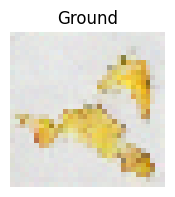

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 815ms/step - loss: 0.1440
Epoch 421/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0788
Epoch 422/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0886
Epoch 423/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0591
Epoch 424/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0538
Epoch 425/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0819
Epoch 426/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0661
Epoch 427/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0927
Epoch 428/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0914
Epoch 429/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0591
Epoch 430/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0817
Epoch 431/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0814
Epoch 432/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0600
Epoch 433/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0603
Epoch 434/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.46it/s]                         


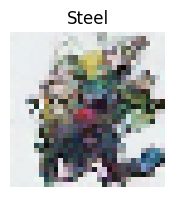

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 814ms/step - loss: 0.0680
Epoch 441/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1039
Epoch 442/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0892
Epoch 443/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1343
Epoch 444/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1167
Epoch 445/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0847
Epoch 446/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1025
Epoch 447/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1449
Epoch 448/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0916
Epoch 449/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1459
Epoch 450/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1453
Epoch 451/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0863
Epoch 452/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1397
Epoch 453/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0677
Epoch 454/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.52it/s]                         


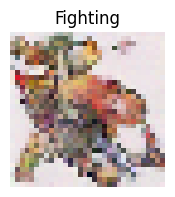

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 812ms/step - loss: 0.0918
Epoch 461/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0732
Epoch 462/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1293
Epoch 463/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0776
Epoch 464/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1058
Epoch 465/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0805
Epoch 466/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0658
Epoch 467/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1102
Epoch 468/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1128
Epoch 469/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0991
Epoch 470/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0869
Epoch 471/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0788
Epoch 472/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1177
Epoch 473/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0613
Epoch 474/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.62it/s]                         


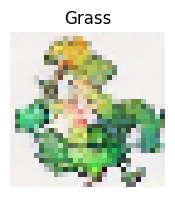

31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 809ms/step - loss: 0.0706
Epoch 481/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0610
Epoch 482/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0638
Epoch 483/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1006
Epoch 484/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0989
Epoch 485/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0948
Epoch 486/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0913
Epoch 487/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0792
Epoch 488/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0888
Epoch 489/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0681
Epoch 490/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0884
Epoch 491/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0898
Epoch 492/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0672
Epoch 493/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0872
Epoch 494/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89

Sampling sprite: 500it [00:21, 23.52it/s]                         


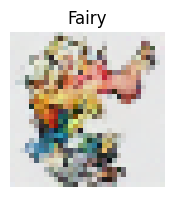

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 812ms/step - loss: 0.0709


In [15]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/6


Sampling sprite: 500it [00:21, 23.60it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:20, 23.89it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:20, 24.11it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:20, 24.07it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:20, 24.20it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:20, 24.15it/s]                         


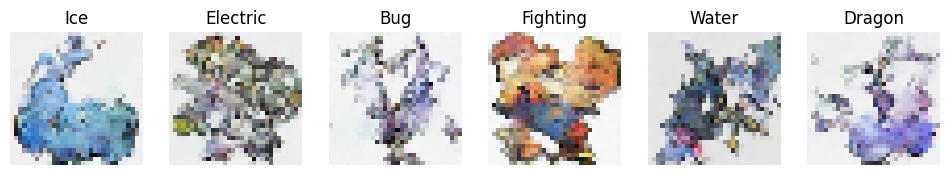

Generating sample 1/3


Sampling sprite: 500it [00:20, 24.49it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:20, 24.50it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:20, 24.75it/s]                         


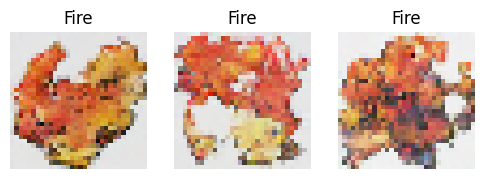

Generating sample 1/3


Sampling sprite: 500it [00:20, 24.59it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:20, 24.87it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:20, 24.77it/s]                         


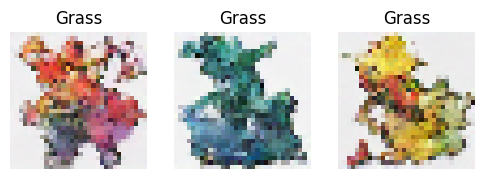

Generating sample 1/3


Sampling sprite: 500it [00:20, 24.50it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:20, 24.53it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:20, 24.61it/s]                         


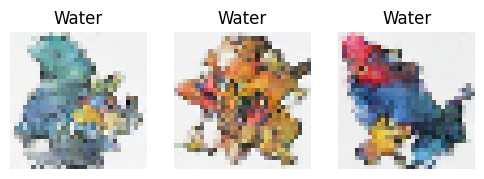

In [16]:
model.plot_samples(6)

model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

Generating sample 1/6


Sampling sprite: 500it [00:19, 25.05it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:19, 25.14it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:19, 25.21it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:20, 24.61it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:20, 24.94it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:20, 24.94it/s]                         


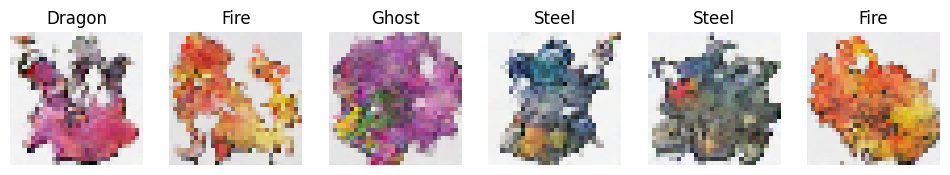

Generating sample 1/6


Sampling sprite: 500it [00:19, 25.05it/s]                         


Generating sample 2/6


Sampling sprite: 500it [00:19, 25.12it/s]                         


Generating sample 3/6


Sampling sprite: 500it [00:19, 25.33it/s]                         


Generating sample 4/6


Sampling sprite: 500it [00:19, 25.36it/s]                         


Generating sample 5/6


Sampling sprite: 500it [00:19, 25.34it/s]                         


Generating sample 6/6


Sampling sprite: 500it [00:19, 25.28it/s]                         


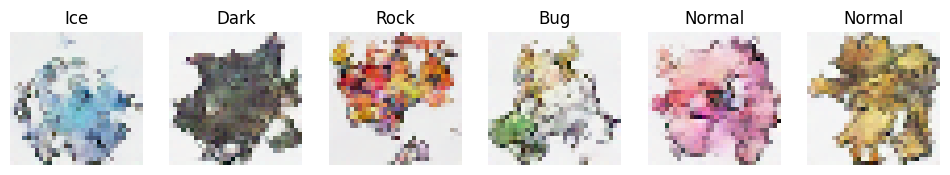

In [21]:
model.plot_samples(6)
model.plot_samples(6)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [35]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [39]:
# Save the model
SCHEDULER = "linear"
IMG_SIZE = 32
BATCH_SIZE = 128
EPOCHS = 600
T = 500
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm"

save_model(model, model_name)

Model diffusion_32_128_600_500_linear_ddpm, saved successfully!


In [40]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

TypeError: <class 'src.model.overfitting_test.DiffusionModel'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'src.model.overfitting_test', 'class_name': 'DiffusionModel', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'DiffusionModel', 'compile_config': {'loss': {'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'name': 'mean_squared_error', 'reduction': 'sum_over_batch_size'}, 'registered_name': None}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class 'src.model.overfitting_test.DiffusionModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of DiffusionModel from its config.

Received config={'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: DiffusionModel.__init__() got an unexpected keyword argument 'trainable'

[BACK TO TOP](#top)